In [67]:
import re
from pathlib import Path

import requests
from bs4 import BeautifulSoup

BASE = "https://www.histdata.com"

def fetch_form_fields(session: requests.Session, final_url: str) -> dict:
    """
    Download the 'final' page and extract the hidden POST fields required by /get.php.
    """
    r = session.get(final_url, timeout=60)
    r.raise_for_status()

    soup = BeautifulSoup(r.text, "lxml")

    # HistData commonly puts the download form inside a hidden div (style="display:none;")
    hidden_div = soup.find("div", attrs={"style": re.compile(r"display\s*:\s*none", re.I)})
    if hidden_div is None:
        raise RuntimeError("Could not find hidden form container (display:none). Page structure may have changed.")

    form = hidden_div.find("form")
    if form is None:
        raise RuntimeError("Could not find hidden <form> in the hidden container. Page structure may have changed.")

    fields = {}
    for k in ("tk", "date", "datemonth", "platform", "timeframe", "fxpair"):
        inp = form.find("input", attrs={"id": k}) or form.find("input", attrs={"name": k})
        if inp is None or not inp.get("value"):
            raise RuntimeError(f"Missing required field '{k}' on final page.")
        fields[k] = inp["value"]

    return fields

def download_zip(final_url: str, out_dir: str = "histdata_downloads") -> Path:
    """
    Uses the hidden form fields from final_url and POSTs them to /get.php to get the ZIP.
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    with requests.Session() as s:
        s.headers.update({"User-Agent": "Mozilla/5.0"})

        fields = fetch_form_fields(s, final_url)

        # Use the same Origin/Referer pattern shown in public examples :contentReference[oaicite:1]{index=1}
        headers = {
            "Origin": BASE,
            "Referer": final_url,
        }

        resp = s.post(f"{BASE}/get.php", data=fields, headers=headers, stream=True, timeout=300)
        resp.raise_for_status()

        # Reasonable filename convention (you can also parse the visible filename text if you prefer)
        zip_name = f"HISTDATA_{fields['platform']}_{fields['fxpair']}_{fields['timeframe']}_{fields['datemonth']}.zip"
        out_path = out_dir / zip_name

        with out_path.open("wb") as f:
            for chunk in resp.iter_content(chunk_size=1024 * 1024):
                if chunk:
                    f.write(chunk)

        return out_path

final = "https://www.histdata.com/download-free-forex-historical-data/?/ascii/1-minute-bar-quotes/eurusd/2025"
path = download_zip(final)
print("Saved:", path)


Saved: histdata_downloads/HISTDATA_ASCII_EURUSD_M1_2025.zip


HISTDATA_ASCII_EURUSD_M1_2025.zip


In [ ]:
import pandas as pd

hist_df = pd.read_csv('../data/raw/currencies/minute_bars/DAT_ASCII_EURUSD_M1_2025.csv',delimiter=';',header=None,names=['timestamp','open','high','low','close','volume'])


In [ ]:
frd_df = pd.read_csv('../data/raw/currencies/minute_bars/EURUSD_full_1min.txt',header=None,names=['date','time','open','high','low','close','volume'])
frd_df['timestamp'] = pd.to_datetime(frd_df['date'].astype(str) + ' ' + frd_df['time'], format='%Y%m%d %H:%M:%S')
frd_df = frd_df[['timestamp','open','high','low','close','volume']]
frd_df = frd_df.sort_values('timestamp').reset_index(drop=True)

hist_df['timestamp'] = pd.to_datetime(hist_df['timestamp'], format='%Y%m%d %H%M%S')

<Axes: xlabel='timestamp'>

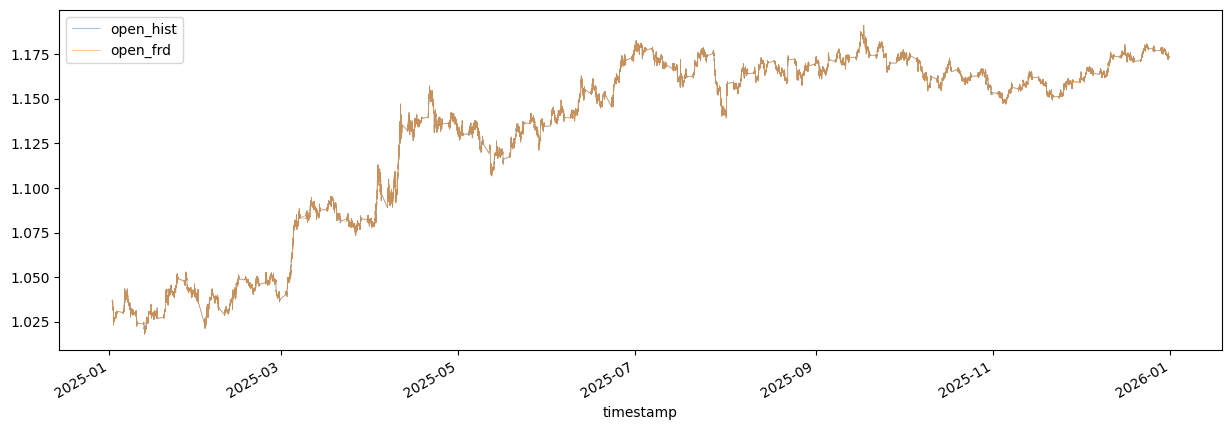

In [61]:
merged = hist_df.merge(frd_df, on='timestamp', suffixes=('_hist', '_frd'), how='inner')
merged.plot(x='timestamp', y=['open_hist', 'open_frd'], figsize=(15, 5), linewidth=0.5, alpha=0.6)

<Axes: xlabel='close_hist', ylabel='close_frd'>

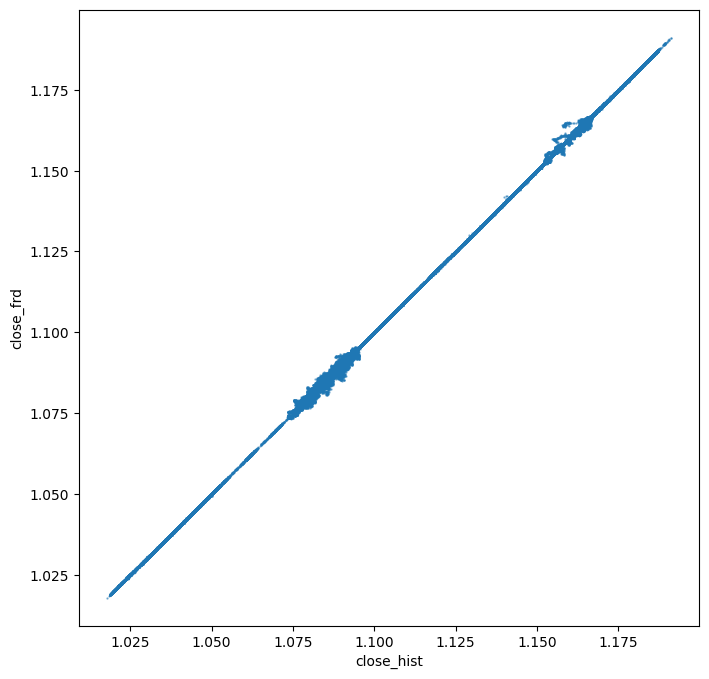

In [66]:
# scatter plot with marker size 0.5
merged.plot(x='close_hist', y='close_frd', kind='scatter', figsize=(8, 8), s=0.5, alpha=0.5)
